In [1]:
#Imports
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize, fsolve, root
from tqdm import tqdm

#Mise en place de l'algo des SVM sur des données quelconques

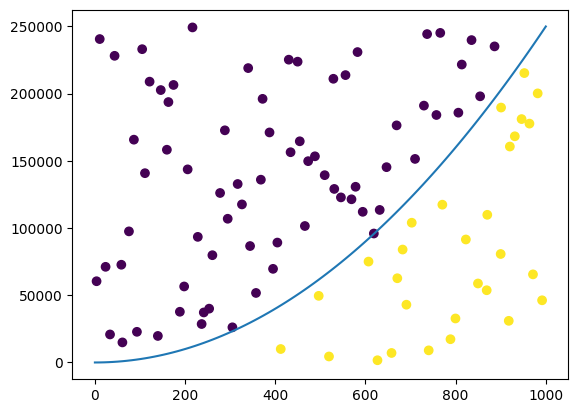

In [ ]:
#Données

def f(x):
  y = np.log(1+x) + (1/4)*x**2 - 7
  return y

xlim = 1000
ylim = f(xlim)
n_data = 100

"""
data = np.random.rand(n_data,2) #choix aléatoire sans carré latin
data[:,0] *= xlim
data[:,1] *= ylim
"""

sampler = qmc.LatinHypercube(d=2) #Méthode des carrés latins.
sample = sampler.random(n=n_data)
sample[:,0] *= xlim
sample[:,1] *= ylim
data = sample

values = np.apply_along_axis(f, 0, data[:,0])
labels = 2*(values > data[:,1]) - 1 #labels -1 ou 1

def label_from_point(p): #on généralise ce qui sera utile pour ajouter des points dans la partie refinement
    x = p[0]
    y = p[1]
    return 2*(f(x) > y) - 1

plt.scatter(data[:,0], data[:,1], c=labels) #données
plt.plot(np.linspace(0,xlim,100), f(np.linspace(0,xlim,100))) #le plan a retrouver par SVM
plt.show()

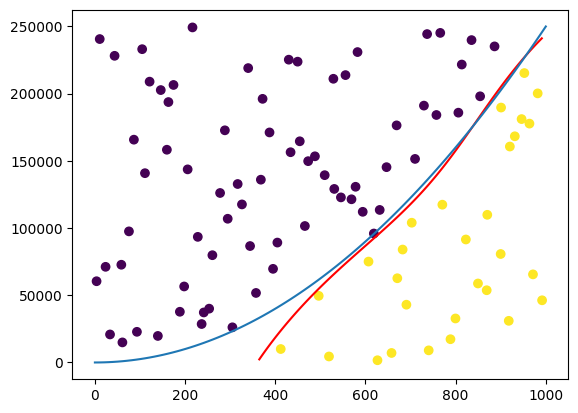

In [ ]:
#training

SVCl = sklearn.svm.SVC(gamma=0.5)
clf = make_pipeline(StandardScaler(), SVCl)
clf.fit(data, labels)

#plot du plan contenu dans le SVM
X = data
y = labels
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.plot(np.linspace(0,xlim,100), f(np.linspace(0,xlim,100))) #le plan a retrouver par SVM en bleu
plt.show()

##Affinage avec la méthode qui marche pas bien

In [ ]:
#Partie "refinement" méthode root + minimize

n_ref = 20
or_data = data.copy()

def inv_dist_nearest(x, d):
    #d : data
    return 1/(1+np.min(np.sum((x-d)**2, axis=1)))

def decision(x, c):
    #c : le classifier
    return (c.decision_function([x])[0],0) #on ajoute un 0 car pour fsolve besoin e dim output = dim input. C'est artificiel mais ca fonctionne plutôt bien ici.

def rbf(x, xp, sigma):
    return np.exp(-((x-xp)**2)/(2*sigma**2))

#print(decision(np.array([(xmin+xmax)/2, f((xmin+xmax)/2)])))

for step in range(0,n_ref+1):
    xmin = min(data[:,0])
    xmax = max(data[:,0])
    ymin = min(data[:,1])
    ymax = max(data[:,1])

    #On calcule une racine comme poin de départ pour l'opti
    fun_des = lambda x: decision(x, clf) #lambda calcul
    root = fsolve(fun_des, np.array([(xmin+xmax)/2, f((xmin+xmax)/2)]))

    fun_opt = lambda x: inv_dist_nearest(x, data) #lambda calcul
    res = minimize(
        fun = fun_opt,
        x0 = root,
        constraints = {'type': 'eq', 'fun': fun_des},
        bounds = [(xmin, xmax), (ymin, ymax)],
        method = 'SLSQP')
    x_r = res.x #point, à priori sur la courbe du SVM, minimisant l'inverse de la distance à son point le plus proche


    """
    support_vectors = clf.support_vectors_      # x_i
    dual_coefs = clf.dual_coef_[0]              # alpha_i * y_i
    intercept = clf.intercept_[0]               # b
    def f_svc(x): #équation du SVC, oui finalement c'est possible j'ai juste mongolisé
        return intercept + np.sum(dual_coefs * rbf(x, support_vectors, 0.5))
    """

    data = np.concatenate((data, [x_r]), axis=0)
    labels = np.concatenate((labels, [label_from_point(x_r)]), axis=0)
    clf.fit(data, labels)


##Affinage avec la méthode qui marche

In [ ]:
#Partie refinement, méthode avec grille

n_ref = 20
n_pos = 100

#contours :
xmin = min(data[:,0])
xmax = max(data[:,0])
ymin = min(data[:,1])
ymax = max(data[:,1])

x_pos = np.linspace(xmin, xmax, n_pos)
y_pos = np.linspace(ymin, ymax, n_pos)

def coord(i,j):
    return np.array([x_pos[i], y_pos[j]])

clf_grid = np.zeros((n_pos, n_pos)) #stocke les valeurs du svc sur la grille. permet donc de trouver les (quasi) zéros considérés pour ensuite calculer notre point de refinement
for i in range(n_pos):
    for j in range(n_pos):
        clf_grid[i,j] = clf.decision_function([coord(i,j)])[0]

dist_nearest_grid = np.zeros((n_pos, n_pos))
for i in range(n_pos):
    for j in range(n_pos):
        dist_nearest_grid[i,j] = np.min(np.sum((coord(i,j)-data)**2, axis=1))

seuil_tol = 10**(-2)
#print(np.sum(np.abs(clf_grid) < seuil_tol)) on en compte 20 par exemple ici, donc c'est pas trop mal. On choisit parmi les 20 lequel a une plus grande val de dist_nearest


for step in tqdm(range(0,n_ref)):
    clf_zeros_mask = np.abs(clf_grid) < seuil_tol
    ijs = np.where(clf_zeros_mask) #indices dans la matrice npos*npos où on a nos quasi-zéros
    #n_zeros = len(ijs[0])
    #print(n_zeros)
    argm = np.argmax(dist_nearest_grid[clf_zeros_mask]) #l'argmax retrouvé est celui de la version flat de la matrice, qui est de dim n_zeros*n_zeros
    #print(dist_nearest_grid[clf_zeros_mask].shape)
    i = ijs[0][argm]
    j = ijs[1][argm]
    x_r = coord(i,j)
    data = np.concatenate((data, [x_r]), axis=0)
    labels = np.concatenate((labels, [label_from_point(x_r)]), axis=0)
    clf.fit(data, labels)
    #mise à jour des grilles :
    for i in range(n_pos):
        for j in range(n_pos):
            dist_nearest_grid[i,j] = min(dist_nearest_grid[i,j], np.sum((coord(i,j)-x_r)**2))
            #soit le point le plus proche l'est tjrs, soit c'est le nouveau point x_r. on prend donc le min des dist.
            clf_grid[i,j] = clf.decision_function([coord(i,j)])[0]
            #pas de raccourci pou l'update de celui-la malheureusement, il faut tout recalculer.



  0%|          | 0/20 [00:00<?, ?it/s]

23
(23,)


  5%|▌         | 1/20 [00:06<02:10,  6.86s/it]

24
(24,)


 10%|█         | 2/20 [00:14<02:14,  7.48s/it]

27
(27,)


 15%|█▌        | 3/20 [00:22<02:05,  7.39s/it]

25
(25,)


 20%|██        | 4/20 [00:29<01:58,  7.42s/it]

26
(26,)


 25%|██▌       | 5/20 [00:37<01:53,  7.58s/it]

27
(27,)


 30%|███       | 6/20 [00:44<01:43,  7.38s/it]

27
(27,)


 35%|███▌      | 7/20 [00:52<01:38,  7.54s/it]

24
(24,)


 40%|████      | 8/20 [01:03<01:43,  8.58s/it]

24
(24,)


 45%|████▌     | 9/20 [01:10<01:28,  8.08s/it]

28
(28,)


 50%|█████     | 10/20 [01:23<01:36,  9.66s/it]

24
(24,)


 55%|█████▌    | 11/20 [01:31<01:24,  9.39s/it]

23
(23,)


 60%|██████    | 12/20 [01:44<01:23, 10.41s/it]

30
(30,)


 65%|██████▌   | 13/20 [01:57<01:18, 11.17s/it]

32
(32,)


 70%|███████   | 14/20 [02:04<00:59,  9.92s/it]

29
(29,)


 75%|███████▌  | 15/20 [02:12<00:46,  9.26s/it]

26
(26,)


 80%|████████  | 16/20 [02:20<00:35,  8.84s/it]

23
(23,)


 85%|████████▌ | 17/20 [02:27<00:24,  8.26s/it]

25
(25,)


 90%|█████████ | 18/20 [02:35<00:16,  8.14s/it]

23
(23,)


 95%|█████████▌| 19/20 [02:41<00:07,  7.77s/it]

27
(27,)


100%|██████████| 20/20 [02:49<00:00,  8.49s/it]


In [ ]:
#cellule de tests

mat = np.array([[1,2],[3,4]])
mask = mat < 4
print(mat[mask])
ijs = np.where(mask)
print(ijs)

[1 2 3]
(array([0, 0, 1]), array([0, 1, 0]))


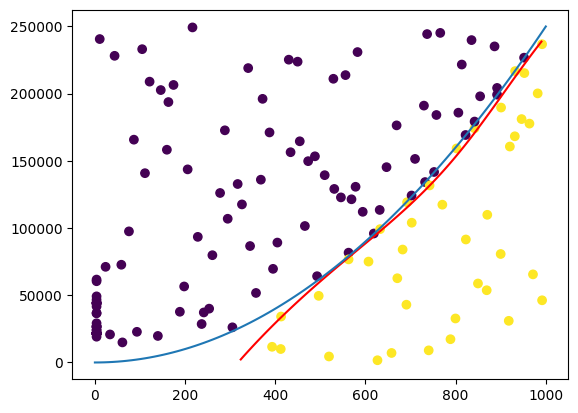

In [ ]:
#Observons à présent le plot du SVM mis à jour
x_min = min(data[:,0])
x_max = max(data[:,0])
y_min = min(data[:,1])
y_max = max(data[:,1])
X = data
y = labels
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.plot(np.linspace(0,xlim,100), f(np.linspace(0,xlim,100))) #le plan a retrouver par SVM en bleu
plt.show()

#Modèle physique de la clarinette (Par Coline, modèle Olivier)

Temps d'exécution (s) : 6.702665090560913


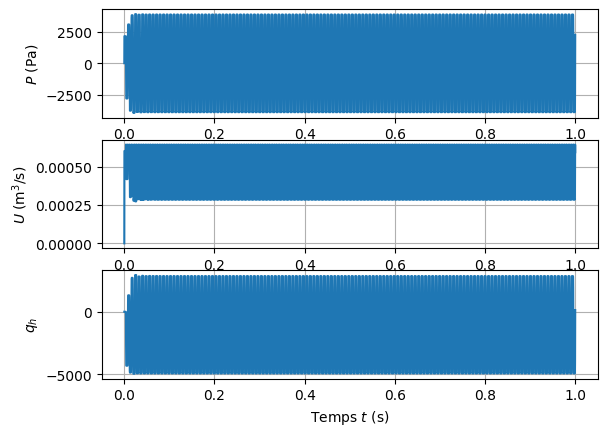

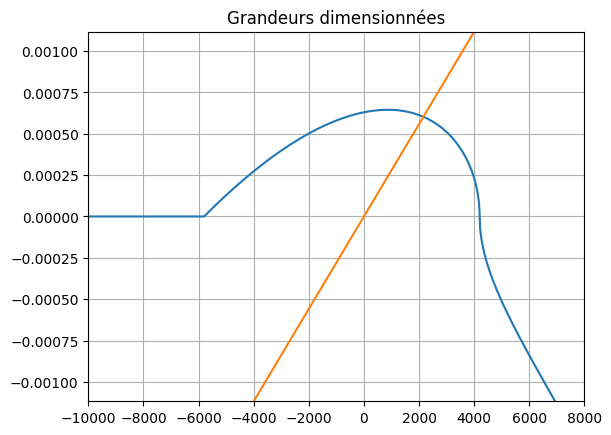

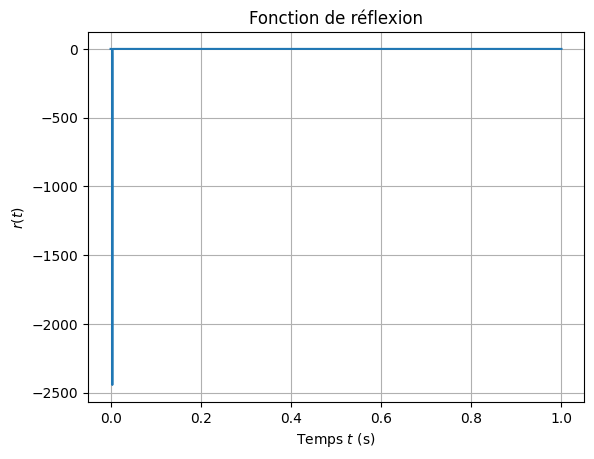

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import os
from time import time
from numba import njit

# PARAMETRES PHYSIQUES ET VARIABLES

T_sec = 1           # durée simulée (s)

# Paramètres physiques

T_deg = 20             # température (°C)
T_K = 273.15 + T_deg   # température (K)
c = 20.05*np.sqrt(T_K) # vitesse du son (m/s)
rho = 1.292*273.15/T_K # masse volumique de l'air (kg/m^3)

# Paramètres d'anche et de résonateur

H = 10**(-3)           # ouverture d'anche au repos (m)
w = 1.3*10**(-2)       # largeur du canal d'anche (m)
P_M = 10*10**3         # pression de plaquage (Pa)
Ks = P_M / H           # raideur anche (Pa/m)
gamma = 0.42           # pression dans la bouche adimensionnée --> entre 1/3 et 1/2
P_m = gamma * P_M      # pression dans la bouche (Pa)
zeta = 0.6             # paramètre d'ouverture d'anche adimensionné --> entre 0.2 et 0.6
U_A = w*H*np.sqrt(2/rho*P_M)
Zc = zeta*P_M/U_A      # impédance caractéristique (kg/s)
S = rho*c/Zc           # section du résonateur (m^2)
L = 0.66               # longueur du résonateur (m)

# Fréquences théoriques

f_res = c/(4*L)              # fréquence du résonateur
a = np.sqrt(S/np.pi)         # rayon du tube
Delta_L = (8*np.pi/3)*a
f_ray = c/(4*(L + Delta_L))  # fréquence avec le rayonnement


# Paramètres utiles pour la simulation

T = 2*L/c               # temps de parcours d'un aller-retour (s)
delta_t = T/128         # pas de temps (s)



# FONCTIONS

# Fonction de réflexion
@njit
def reflexion(t, width_T=0.1, T=T):
    """
    Fonction de réflexion r(t), de la forme gaussienne :
        r(t) = a * exp[-b(t-T)^2]

    Parameters
    ----------
        t : float ou array, instant temporel >= 0 (s)
        width_T : float, largeur à mi-hauteur en proportion de T (en %)
        T : float, temps de parcours aller-retour (s)

    Returns
    -------
        float ou array, valeur de la fonction de réflexion en t
    """
    b = 4 * np.log(2) / (width_T*T)**2
    gauss = np.exp(-b * (t-T)**2)
    A = np.trapz(gauss, dx=delta_t) # intégration trapézoïdale
    a = -1/A
    return a*gauss


# Caractéristique non-linéaire
@njit
def F(P, gamma, zeta, P_M, Zc):
    """
    Caractéristique non-linéaire F telle que u = F(P_m-p)

    Parameters
    ----------
        P : float, pression dans le bec (Pa)
        gamma : float, pression dans la bouche adimensionnée
        zeta : float, paramètre d'ouverture d'anche adimensionné
        P_M : float, pression de plaquage
        Zc : float, impédance caractéristique
    Returns
    -------
        U : float, débit volumique dans le bec
    """
    p = P/P_M # pression adimensionnée
    if np.abs(gamma-p) <= 1:
        u = zeta * (1+p-gamma) * np.sqrt(np.abs(gamma-p)) * (gamma-p)/np.abs(gamma-p) # débit adimensionné
    else :
        u = 0
    U = u*P_M/Zc # débit dimensionné
    return U

@njit
def func_dicho(P, params):
    """
    Fonction dont on veut trouver le zéro par dichotomie

    Parameters
    ----------
        P : float, valeur de la pression dans le bec à laquelle on évalue la fonction
        params : array
    """
    qh = params[0]
    gamma = params[1]
    zeta = params[2]
    P_M = params[3]
    Zc = params[4]
    return F(P, gamma, zeta, P_M, Zc) - 1/Zc*(P-qh)

@njit
def dichotomie(func, params, a, b, n, tol=1e-9):
    """
    Trouver l'abcisse m tel que func(m) = 0 par dichotomie

    Parameters
    ----------
        func : fonction, fonction dont on cherche l'annulation
        params : array, paramètres d'entrée de la fonction
        a : float, borne minimale de l'intervalle de recherche
        b : float, borne maximale de l'intervalle de recherche
        tol : float, tolérance de précision sur la valeur de l'abcisse obtenue

    Returns
    -------
        m : float, abcisse pour laquelle la fonction s'annule
    """

    if func(a,params)*func(b,params) > 0:
        print("Mauvais choix des bornes de l'intervalle, n=",n)
    else :
        m = (a+b)/2

        while np.abs(a-b) > tol:
            if func(m,params) == 0.:
                return m
            elif func(a,params)*func(m,params) > 0:
                a = m
            else :
                b = m
            m = (a+b)/2

        return m


# BOUCLE TEMPORELLE
@njit
def execution(T_sec, delta_t, gamma, zeta, P_M, Zc):

    temps = np.arange(0, T_sec, delta_t)
    N = len(temps)

    # Initialisation
    U, P, qh = np.zeros(N), np.zeros(N), np.zeros(N)

    # Calcul des fonctions de réflexion
    Lwin = int(5 * T / delta_t)
    t_win = np.arange(0, Lwin) * delta_t
    r = reflexion(t_win)
    r_reverse = r[::-1].copy()

    # Initialisation du buffer circulaire
    outgoing_hist = np.zeros(Lwin)

    # Boucle
    for n in range(1,N):

        # calcul de qh à l'instant t
        qh[n] = np.dot(r_reverse, outgoing_hist) * delta_t

        # calcul de q et f à l'instant t
        # trouver l'intersection entre la courbe F(P) et la droite U = 1/Zc*(P-qh) par dichotomie
        P[n] = dichotomie(func_dicho, [qh[n], gamma, zeta, P_M, Zc], -P_M, P_M, n)
        U[n] = F(P[n], gamma, zeta, P_M, Zc)


        # Mise à jour du buffer circulaire (rotation + ajout)
        w_new = P[n] + Zc * U[n]
        # Rotation des buffers
        outgoing_hist[:-1] = outgoing_hist[1:]
        outgoing_hist[-1] = w_new

    return temps, U, P, qh, r

start = time()
temps, U, P, qh, r = execution(T_sec, delta_t, gamma, zeta, P_M, Zc)
stop = time()

def simulation(T_sec, delta_t, gamma, zeta, P_M, Zc, ret_time=False): #Remise en forme pour pouvoir cartographier ensuite
    start = time()
    _, _, P, _, _ = execution(T_sec, delta_t, gamma, zeta, P_M, Zc)
    stop = time()
    if ret_time:
        return P, stop-start
    else:
        return P

print("Temps d'exécution (s) :", stop-start)

# AFFICHAGE

plt.figure()
plt.subplot(311)
plt.plot(temps,P)
plt.ylabel(r"$P$ (Pa)")
plt.grid()

plt.subplot(312)
plt.plot(temps,U)
plt.ylabel(r"$U$ (m$^3$/s)")
plt.grid()

plt.subplot(313)
plt.plot(temps,qh)
plt.xlabel(r"Temps $t$ (s)")
plt.ylabel(r"$q_h$")
plt.grid()
plt.show()

#%%

Pvals = np.linspace(-10000,8000,1000)
Uvals = np.zeros(len(Pvals))
for i in range(len(Pvals)):
    Uvals[i] = F(Pvals[i], gamma, zeta, P_M, Zc)

uvals = Uvals*Zc/P_M
pvals = Pvals/P_M

U_droite = 1/Zc * (Pvals-1)
u_droite = U_droite*Zc/P_M

plt.figure()
plt.plot(Pvals,Uvals)
plt.plot(Pvals,U_droite)
plt.grid()
plt.title("Grandeurs dimensionnées")
plt.xlim(-10000,8000)
plt.ylim(-0.4*P_M/Zc,0.4*P_M/Zc)


refl = reflexion(temps)
plt.figure()
plt.plot(temps,refl)
plt.xlabel(r"Temps $t$ (s)")
plt.ylabel(r"$r(t)$")
plt.title("Fonction de réflexion")
plt.grid()

##Définition des différents descripteurs

In [ ]:
#Calculs des descripteurs = labels des points de la cartographie

def epsilon1(P): # établit si oui ou non il y a du son
    eps = 0.1 # valeur arbitraire, aucune valeur donnée dans le papier de Christophe mais d'après les figures données 10 devrait suffire, P n'excédant pas 0.05 en fin de signal.
    n = len(P)
    moy_last = np.abs((1/n)*np.sum(P[n-(n//3+1):n]))
    #print(moy_last)
    lab = 2*(moy_last > eps)-1 # on prend sur les n//3 derniers samples.
    return lab

def ecart_freq(P, f_ray, Nfft=1024, delta_t=1/44100): # calcule l'écart entre la fréquence de jeu rayonnée théorique, et la fréquence percue, puis renvoie un booléan si l'écart dépasse 5 cent.
    n = len(P)
    spec = np.fft.fft(P, n=Nfft)
    fftFreq_hz_v = np.fft.fftfreq(Nfft, delta_t)
    fftAmpl_v = np.abs(spec)

    #calcul du produit spectral et estimation de f0
    H = 4
    R = Nfft//(2*H)
    sr_hz = 1/delta_t
    fmin_hz = 20
    fmax_hz = 500
    spFreq_hz_v = fftFreq_hz_v[:R]
    spAmpl_v = np.ones(R)
    for h in range(1,H+1):
        spAmpl_h = fftAmpl_v[::h]
        if spAmpl_h.shape[0] < R:
            spAmpl_h = np.concatenate((spAmpl_h, np.zeros(R-spAmpl_h.shape[0])))
        else:
            spAmpl_h = spAmpl_h[:R]
        spAmpl_v = spAmpl_v*(spAmpl_h**2)
    nmin = int(fmin_hz/(sr_hz)*Nfft)
    nmax = int(fmax_hz/(sr_hz)*Nfft)
    if nmax > R-1:
        nmax = R-1
    idx_max = np.argmax(spAmpl_v[nmin:nmax+1])
    f0_Hz =  spFreq_hz_v[nmin + idx_max]

    delta_f_cent = np.abs(1200 * (np.log(f0_Hz/f_ray)/np.log(2)))
    lab = 2*(delta_f_cent > 5)-1
    return lab

#Cartographie du modèle avec pour paramètres variables gamma et zeta adimensionnés

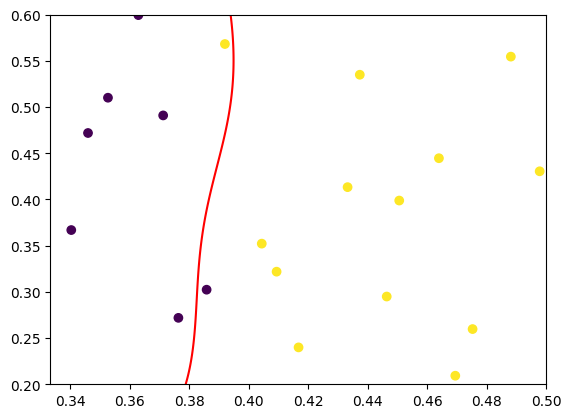

In [9]:
gmin = 1/3
gmax = 1/2
zmin = 0.2
zmax = 0.6

gammas = np.linspace(gmin,gmax,50)
zetas = np.linspace(zmin,zmax,50)
n_sim = 20 # 20 points de départ

#définissons les 20 premiers échantillons avec un carré latin :

sampler = qmc.LatinHypercube(d=2) #Méthode des carrés latins, résultats entre 0 et 1 exclus.
sample = sampler.random(n=n_sim)
g_width = gmax-gmin
z_width = zmax-zmin
sample[:,0] *= g_width
sample[:,0] += gmin
sample[:,1] *= z_width
sample[:,1] += zmin
data = sample

labels = np.zeros(n_sim)

for s in range(n_sim): #Calcul des labels
    g = sample[s,0]
    z = sample[s,1]
    Zc = z*P_M/U_A
    P = simulation(T_sec, delta_t, g, z, P_M, Zc)
    labels[s] = epsilon1(P)

#print(labels)

SVCl = sklearn.svm.SVC(gamma='auto')
clf = make_pipeline(StandardScaler(), SVCl)
clf.fit(data, labels)
plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.show()



##Première méthode d'affinage

Elle ne marche pas vraiment ducoup, cela consistait à trouver une racine du SVM puis à minimiser l'inverse de la distance au plus proche (donc à la maximiser) pour trouver le point d'étude. Ici le code est même incomplet et on ne calcule pas la dite racine, mais une version où c'est fait est utilisée plus haut sur des données synthétiques.

In [ ]:
n_ref = 20
or_data = data.copy()

def m_dist_nearest(x): #negatif car on veut le point le plus loin, donc pour maximiser la fonction on minimise sa negation.
    return 1/(1+np.min(np.sum((x-or_data)**2, axis=1)))

def decision(x):
    return clf.decision_function([x])[0]

for step in range(0,n_ref+1):
    xmin = min(data[:,0])
    xmax = max(data[:,0])
    ymin = min(data[:,1])
    ymax = max(data[:,1])
    res = minimize(
        fun=m_dist_nearest,
        x0=np.array([(xmin+xmax)/2, (ymin+ymax)/2]),
        constraints={'type': 'eq', 'fun': decision},
        bounds=[(xmin, xmax), (ymin, ymax)],  # optional
        method='SLSQP'
    )
    x_r = res.x
    data = np.concatenate((data, [x_r]), axis=0)
    labels = np.concatenate((labels, [epsilon1(simulation(T_sec, delta_t, x_r[0], x_r[1], P_M, Zc))]), axis=0)
    clf.fit(data, labels)

##Deuxième méthode

Plus coûteuse, mais à l'avantage de bien fonctionner. On crée une grille de l'espace et en chaque point on tiens à jour la valeur du SVM et la distance au point d'entraînement le plus proche. Cela permet donc de trouver les valeurs quasi nulles du SVM, puis de choisir la position qui maximise la distance au point le plus proche pour trouver notre point d'affinage.

In [12]:
#Partie refinement, méthode avec grille

n_ref = 50
n_pos = 100

#contours :
xmin = min(data[:,0])
xmax = max(data[:,0])
ymin = min(data[:,1])
ymax = max(data[:,1])

x_pos = np.linspace(xmin, xmax, n_pos)
y_pos = np.linspace(ymin, ymax, n_pos)

def coord(i,j):
    return np.array([x_pos[i], y_pos[j]])

clf_grid = np.zeros((n_pos, n_pos)) #stocke les valeurs du svc sur la grille. permet donc de trouver les (quasi) zéros considérés pour ensuite calculer notre point de refinement
for i in range(n_pos):
    for j in range(n_pos):
        clf_grid[i,j] = clf.decision_function([coord(i,j)])[0]

dist_nearest_grid = np.zeros((n_pos, n_pos))
for i in range(n_pos):
    for j in range(n_pos):
        dist_nearest_grid[i,j] = np.min(np.sum((coord(i,j)-data)**2, axis=1))

seuil_tol = 10**(-2)
#print(np.sum(np.abs(clf_grid) < seuil_tol)) on en compte 20 par exemple ici, donc c'est pas trop mal. On choisit parmi les 20 lequel a une plus grande val de dist_nearest


for step in tqdm(range(0,n_ref)):
    clf_zeros_mask = np.abs(clf_grid) < seuil_tol
    ijs = np.where(clf_zeros_mask) #indices dans la matrice npos*npos où on a nos quasi-zéros
    #n_zeros = len(ijs[0])
    #print(n_zeros)
    argm = np.argmax(dist_nearest_grid[clf_zeros_mask]) #l'argmax retrouvé est celui de la version flat de la matrice, qui est de dim n_zeros*n_zeros
    #print(dist_nearest_grid[clf_zeros_mask].shape)
    i = ijs[0][argm]
    j = ijs[1][argm]
    x_r = coord(i,j)
    data = np.concatenate((data, [x_r]), axis=0)
    labels = np.concatenate((labels, [epsilon1(simulation(T_sec, delta_t, x_r[0], x_r[1], P_M, Zc))]), axis=0)
    clf.fit(data, labels)
    #mise à jour des grilles :
    for i in range(n_pos):
        for j in range(n_pos):
            dist_nearest_grid[i,j] = min(dist_nearest_grid[i,j], np.sum((coord(i,j)-x_r)**2))
            #soit le point le plus proche l'est tjrs, soit c'est le nouveau point x_r. on prend donc le min des dist.
            clf_grid[i,j] = clf.decision_function([coord(i,j)])[0]
            #pas de raccourci pou l'update de celui-la malheureusement, il faut tout recalculer.

100%|██████████| 50/50 [06:32<00:00,  7.85s/it]


##Plot avec méthode dU SVM, faire tourner la cellule de la grille juste avant

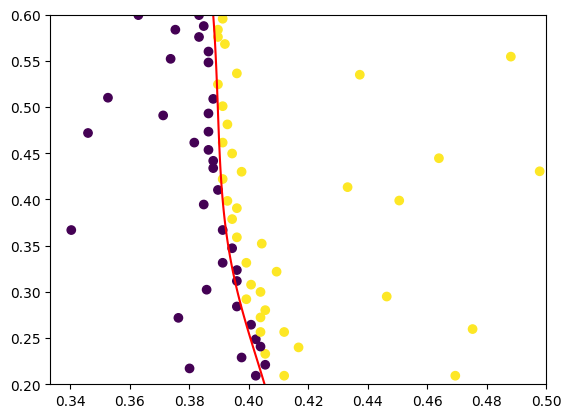

In [13]:
plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.show()

In [12]:
print(np.sum(labels==1)/len(labels))

0.35
